In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from meteostat import Point, Daily, Monthly
import requests
from scipy import stats

In [8]:
cities = pd.read_csv('worldcities.csv')

In [10]:
def find_weather(start_year, end_year, city = None, coordinates = None):
    start = datetime(start_year, 1, 1)
    end = datetime(end_year, 12, 31)
    if city and not coordinates:
        location = Point(list(cities.loc[cities['city'] == city, 'lat'])[0], list(cities.loc[cities['city'] == city, 'lng'])[0])
    elif coordinates and not city:
        location = Point(coordinates[0], coordinates[1])
    else:
        raise Exception('Input city OR coordinates')
        
    weather_data = Monthly(location, start, end)
    weather_data = weather_data.fetch()
    weather_data.reset_index(inplace=True)
    
    if weather_data.empty:
        raise ValueError('No Data for Location')
    out = {}
    
    temp = {}
    for year in range(start_year, end_year +1):
        temp[year] = (np.nanmean(list([weather_data[weather_data['time'].dt.year == year]['tavg']])))
    out['tavg'] = temp
        
    temp = {}
    for year in range(start_year, end_year + 1):
        temp[year] = (np.sum(list([weather_data[weather_data['time'].dt.year == year]['prcp']])))
    out['prcp'] = temp

    
    return out


In [11]:
def find_stock_price(stock, start_year, end_year):
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol=' + stock + '&apikey=WR65UNYM9P18M23Q'
    r = requests.get(url)
    stock_data = r.json()
    stock_data = dict(stock_data)
    df = pd.DataFrame.from_dict(stock_data['Monthly Adjusted Time Series']).transpose()
    df.reset_index(inplace=True)
    
    years = list(range(start_year, end_year + 1))
    years_string = '|'.join([str(x) for x in years])
    subset = df[df['index'].str.contains(years_string)]
    prices = [float(x) for x in list((subset[subset['index'].str.contains('-12-')]['4. close']))]
    prices.reverse()
    out = {years[i] : prices[i] for i in range(len(years))}
    
    return out

In [12]:
def historical_cor(start_year, end_year, stock, cities = None, coordinates = None):
    stock_price = find_stock_price(stock, start_year, end_year)
    stock_price = list(stock_price.values())
    for city in cities:
        for i in range(10):
            weather = find_weather(start_year - i, end_year - i, city = city, coordinates = coordinates)
            for key in weather.keys():
                curr_weth = list(weather[key].values())
                if abs(stats.linregress(stock_price, curr_weth)[2]) > 0.9: 
                    print('There is a correlation of ' + str(stats.linregress(stock_price, curr_weth)[2]) + ' between ' + stock + ' from ' + str(start_year)+ '-' + str(end_year) + ' and ' + key + ' in ' + city + ' from ' + str(start_year - i) + '-' + str(end_year - i))
                    fig=plt.figure()
                    ax=fig.add_subplot(111, label="1")
                    ax2=fig.add_subplot(111, label="2", frame_on=False)
                    
                    ax.plot(list(range(start_year, end_year + 1)), stock_price, color="C0")
                    ax.set_xlabel("Year", color="C0")
                    ax.set_ylabel(str(stock) + ' price from ' + str(start_year) + '-' + str(end_year), color="C0")
                    ax.tick_params(axis='x', colors="C0")
                    ax.tick_params(axis='y', colors="C0")

                    ax2.plot(list(range(start_year - i , end_year - i + 1)), curr_weth, color="C2")
                    ax2.xaxis.tick_top()
                    ax2.yaxis.tick_right()
                    ax2.set_xlabel('Year', color="C2") 
                    ax2.set_ylabel(key + ' in ' + str(city) + ' from ' + str(start_year - i) + '-' + str(end_year - i), color="C2")     
                    ax2.xaxis.set_label_position('top') 
                    ax2.yaxis.set_label_position('right') 
                    ax2.tick_params(axis='x', colors="C2")
                    ax2.tick_params(axis='y', colors="C2")
                    plt.show()
                    
                    sns.regplot(x = stock_price, y = curr_weth)
                    plt.xlabel('Stock Price')
                    plt.ylabel(str(key) + ' in ' + city)
                    plt.show()
        

example

There is a correlation of 0.9064584431782879 between AAPL from 2001-2010 and tavg in Beijing from 1998-2007


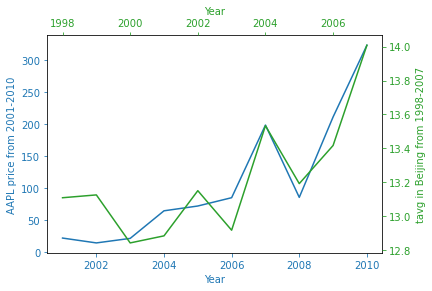

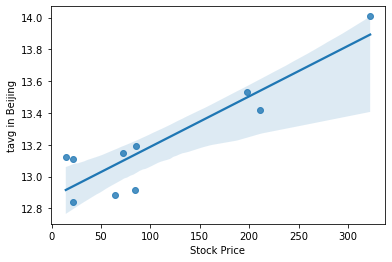

In [13]:
historical_cor(2001, 2010, 'AAPL', ['Beijing'])